# IF evluation beased on Inforbench

In [1]:
import pandas as pd
import time
from openai import OpenAI
from tqdm import tqdm
import os

# Read data using
SYS_MSG = "Based on the provided Input (if any) and Generated Text, answer the ensuing Questions with either a YES or NO choice. Your selection should be based on your judgment as well as the following rules:\n\n- YES: Select 'YES' if the generated text entirely fulfills the condition specified in the question. However, note that even minor inaccuracies exclude the text from receiving a 'YES' rating. As an illustration. consider a question that asks. \"Does each sentence in the generated text use a second person?” If even one sentence does not use the second person, the answer should NOT be 'YES'. To qualify for a 'YES' rating, the generated text must be entirely accurate and relevant to the question\n\n- NO: Opt for 'NO' if the generated text fails to meet the question's requirements or provides no information that could be utilized to answer the question. For instance, if the question asks. \"Is the second sentence in the generated text a compound sentence?\" and the generated text only has one sentence. it offers no relevant information to answer the question. Consequently, the answer should be 'NO'.'''"

foler_path = "Paper Experiment Results/New_filtered/IF"
file_name = "exp_result_Llama-2-70b-chat-hf_20240503111010.csv"
output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
temperature = 0

In [2]:
def extract_final_response(response, prompt):
    return response[len(prompt) :]


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def process_string(input_string):
    processed_string = input_string.strip("[]").replace("\\", "")
    questions = processed_string.split("\n")
    questions = [q.strip("'") for q in questions]
    return questions


_data["pure_response"] = _data.apply(extract_pure_response, axis=1)

In [4]:
data_evaluated = pd.read_csv(output_path)

In [5]:
test_times = 0
times = 0
pbar = tqdm(total=len(_data))
last_idx = data_evaluated.shape[0]
for index, entry in tqdm(_data.iterrows()):
    if index <= last_idx:
        pbar.update(1)
        continue
    updated_row = entry.copy()
    input_task = entry["input"]
    output = entry["pure_response"]
    if output is None:  # skip if result hasn't been generated
        continue
    message = []
    answer = ""
    for question in process_string(entry["decomposed_questions"]):
        if len(message) == 0:
            if input_task:
                content = f'{SYS_MSG}\n\nInput:\n"{input_task}"\n\nGenerated Text:\n"{output}"\n\nQuestion:\n{question}\n'
            else:
                content = f'{SYS_MSG}\n\nGenerated Text:\n"{output}"\n\nQuestion:\n{question}\n'
        else:
            content = f"{question}\n"
        message.append({"role": "user", "content": content})
        # create a chat completion
        success = False
        early_stop = False
        while not success:
            try:
                completion = client.chat.completions.create(
                    model=eval_model,
                    messages=message,
                    temperature=temperature,
                )
                generation = completion.choices[0].message.content
                message.append({"role": "assistant", "content": generation})
                # check if generation is yes or no
                if generation.lower().startswith(
                    "yes"
                ) or generation.lower().startswith("no"):
                    if generation.lower().startswith("yes"):
                        answer += "Yes\n"
                    else:
                        answer += "No\n"
                else:
                    if "YES" in generation and "NO" not in generation:
                        answer += "Yes\n"
                    elif "YES" not in generation and "NO" in generation:
                        answer += "No\n"
                    else:
                        for msg in message:
                            print(msg["content"])
                        print("NO YES or NO answer!" + generation)
                        answer += "None\n"
                        early_stop = True
                        break
                success = True
            except Exception as e:
                print("ERROR!")
                print(e)
                print("Retry!")
                time.sleep(20)

        # when no answer occurs, break the loop and continue to next instance
        if early_stop:
            break

    answer = answer[:-1]
    # save eval results as List[bool]
    bool_results = []
    for i in answer.split("\n"):
        if i == "Yes":
            bool_results.append(True)
        elif i == "No":
            bool_results.append(False)
        else:
            bool_results.append(None)

    updated_row["eval"] = bool_results
    updated_row["messages_openai"] = message
    test_times += 1
    # if test_times > 5:
    #     break
    updated_dataframe = pd.DataFrame([updated_row])
    pbar.update(1)
    if not os.path.exists(output_path):
        updated_dataframe.to_csv(output_path, index=False, mode="w", header=True)
    else:
        updated_dataframe.to_csv(output_path, index=False, mode="a", header=False)
    times = times + 1

 11%|█         | 379/3500 [23:43<57:18:10, 66.10s/it]

ERROR!
Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo-0125 in organization org-EkHurOnEZ1eqBIvuxr1REXMk on requests per day (RPD): Limit 10000, Used 10000, Requested 1. Please try again in 8.64s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
Retry!


 12%|█▏        | 416/3500 [55:30<45:08:40, 52.70s/it]

Based on the provided Input (if any) and Generated Text, answer the ensuing Questions with either a YES or NO choice. Your selection should be based on your judgment as well as the following rules:

- YES: Select 'YES' if the generated text entirely fulfills the condition specified in the question. However, note that even minor inaccuracies exclude the text from receiving a 'YES' rating. As an illustration. consider a question that asks. "Does each sentence in the generated text use a second person?” If even one sentence does not use the second person, the answer should NOT be 'YES'. To qualify for a 'YES' rating, the generated text must be entirely accurate and relevant to the question

- NO: Opt for 'NO' if the generated text fails to meet the question's requirements or provides no information that could be utilized to answer the question. For instance, if the question asks. "Is the second sentence in the generated text a compound sentence?" and the generated text only has one senten

 15%|█▍        | 519/3500 [2:30:16<18:32:40, 22.40s/it]

ERROR!
Connection error.
Retry!
ERROR!
Connection error.
Retry!
ERROR!
Connection error.
Retry!


 15%|█▌        | 526/3500 [2:33:35<8:15:37, 10.00s/it] 

ERROR!
Connection error.
Retry!


919it [6:23:08, 25.02s/it][6:22:28<46:57:49, 65.51s/it]    


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/openai/_base_client.py", line 959, in _request
  File "/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/httpx/_models.py", line 758, in raise_for_status
    raise HTTPStatusError(message, request=request, response=self)
httpx.HTTPStatusError: Client error '429 Too Many Requests' for url 'https://api.openai.com/v1/chat/completions'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/429

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_82927/2366533250.py", line 30, in <module>
    completion = client.chat.completions.create(
  File "/home/lujun/anaconda3/envs/causalLLM/lib/

In [19]:
import pandas as pd
ERROR!
Connection error.
Retry!
 15%|█▌        | 526/3500 [2:33:35<8:15:37, 10.00s/it] 
ERROR!
Connection error.

df = pd.read_csv(
    "/home/lujun/local/temperature_eval/Paper Experiment Results/New_filtered/IF/exp_result_Llama-2-13b-chat-hf_20240503202441_evaluated.csv"
)

In [25]:
def count_true_false(string):
    string_lower = string.lower()
    count_true = string_lower.count("true")
    count_false = string_lower.count("false")
    return count_true, count_false


df[["true_count", "false_count"]] = df["eval"].apply(count_true_false).apply(pd.Series)

In [27]:
df["DRFR"] = df["true_count"] / (df["true_count"] + df["false_count"])

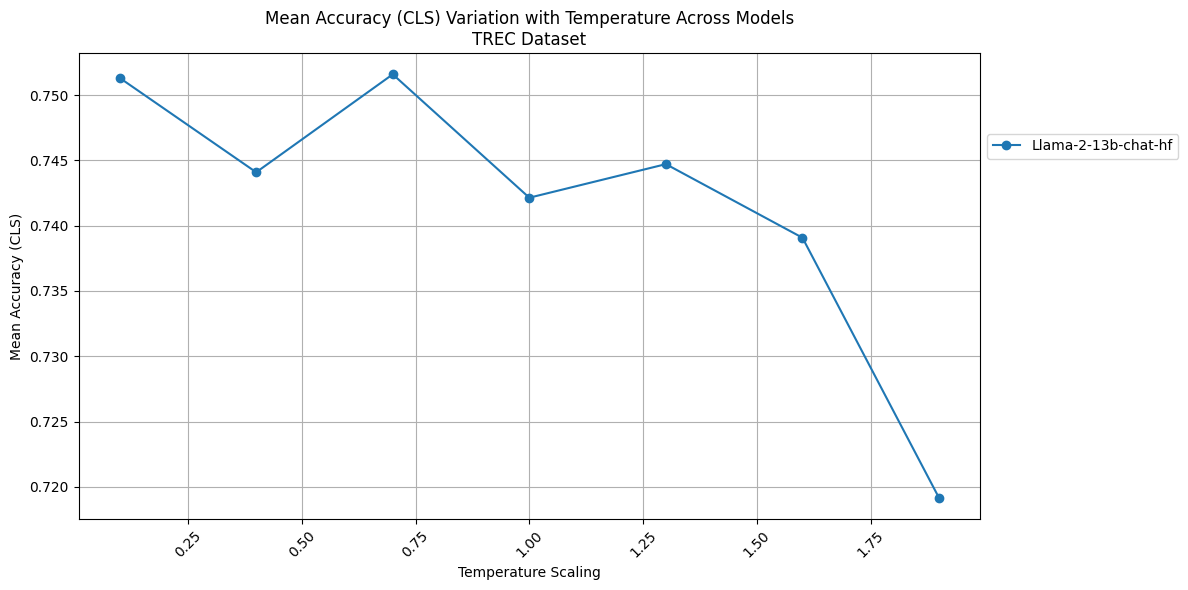

In [28]:
import matplotlib.pyplot as plt

grouped_data = df.groupby(["model", "Temperature"])["DRFR"].mean()

models = df["model"].unique()

plt.figure(figsize=(10, 6))
for model in models:
    model_data = grouped_data[model]
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker="o",
        label=model,
    )

plt.xlabel("Temperature Scaling")
plt.ylabel("Mean Accuracy (CLS)")
plt.title("Mean Accuracy (CLS) Variation with Temperature Across Models\nTREC Dataset")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc="center left", bbox_to_anchor=(1, 0.8))

plt.show()